<a href="https://colab.research.google.com/github/ArielFix/DLINtroProject/blob/main/NLP_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.display import HTML
import subprocess

branch = subprocess.check_output(["git", "rev-parse", "--abbrev-ref", "HEAD"]).decode()[:-1]
HTML('<a href="https://colab.research.google.com/github/ArielFix/DLINtroProject/blob/{branch}/NLP_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>'.format(branch=branch))

CalledProcessError: ignored

## Setup Commands

In [ ]:
!git init .
!git remote add origin https://github.com/ArielFix/DLINtroProject.git
!git fetch
!git checkout main

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import model_selection
from sklearn.metrics import f1_score
import numpy as np
import torch
from torch.utils.data import dataset
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [3]:
from google.colab import drive
import os
import sys

drive.mount('/content/gdrive')
train_path = '/content/gdrive/MyDrive/NLP_Project/data/augmented_train.csv'
test_path = '/content/gdrive/My Drive/NLP_Project/data/test.csv'
sample_submission_path = '/content/gdrive/MyDrive/NLP_Project/data/sample_submission.csv'

GOOGLE_DRIVE_PATH = '/content/gdrive/MyDrive/NLP_Project'
sys.path.append(GOOGLE_DRIVE_PATH)
print(os.listdir(GOOGLE_DRIVE_PATH))

Mounted at /content/gdrive
['data', 'README.md', 'test_augs.py', 'requirements.txt', 'get_roberta_model.py', 'pretrained', 'utilities', 'roberta', 'augmentations', 'NLP_Project.ipynb', '.gitignore', '.idea', 'NLP_Project Roberta.ipynb']


In [4]:
!echo "This may take a while:"
%pip install -q -r /content/gdrive/MyDrive/NLP_Project/requirements.txt # fill here the path to the requirement file

This may take a while:
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 72.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 106.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 107.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 KB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 115.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 KB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 16.7 MB/s eta 0:00:00


In [5]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,1,NaN,NaN,Our human_activity are the understanding of th...,1
2,1,NaN,NaN,Our Deeds are the Reason of this # May ALLAH F...,1
3,1,NaN,NaN,Our Deeds are forgive deed the Allah Reason of...,1
4,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1


**A quick look at our data**
Let's look at our data... first, some examples of what is NOT a disaster tweet.

In [6]:
print('\n' .join(map(str, train_df[train_df["target"] == 0]["text"].values[0:5])))


What's up man?
What's upwards human_being?
's  man?
What's up serviceman man?
What's up man?


And some examples of what is a disaster tweet.

In [7]:
print('\n' .join(map(str, train_df[train_df["target"] == 1]["text"].values[0:5])))

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Our human_activity are the understanding of this #earthquake May Allah forgive us all
Our Deeds are the Reason of this # May ALLAH Forgive us all
Our Deeds are forgive deed the Allah Reason of this America #earthquake May ALLAH Forgive us all
Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all


The words contained in each tweet are a good indicator of whether they're about a real disaster or not. This is not entirely correct, but it's a great place to start.

We'll use scikit-learn's 'train_test_split' for splitting the train data to train and validation sets for monitoring the model training.

In [8]:
train_df, val_df = model_selection.train_test_split(train_df, test_size=0.15, train_size=0.85)

**Our model**

As we mentioned above, we think the words contained in each tweet are a good indicator of whether they're about a real disaster or not. The presence of particular word (or set of words) in a tweet might link directly to whether or not that tweet is real.

We want to modify [twitter-roberta-sentiment](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment) for the classification task of disaster tweets.
First let's load the pretrained model

In [9]:
from pretrained.get_pretrained_roberta import GetPretrainedRoberta 

roberta = GetPretrainedRoberta() #init pretrained roberta model and tokenizer
roberta.model.modules # Shows model's modules

<bound method Module.modules of RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, 

Now, we want our model output layer to be the results o a sigmoid layer, this sigmoid layer should get only one value from the last linear layer.
We will change the linear layer 'out'proj' with 3 outputs into a sequenc which includes the same input size, output size of 1 and a sigmoid.
Additioanly, we want to fine tune the pretained roberta model with the new output layer so we will freeze the entire model except the 'Classifier' module which includes the last layer.  

In [10]:
from pretrained.modify_roberta import ModifyRoberta

ModifyRoberta.modify_binary_output(roberta.model) #change output layer to linear -> sigmoid
ModifyRoberta.modify_only_train_calssifier(roberta.model) #freeze the parameters except the 'Classifier' module
roberta.model.modules


<bound method Module.modules of RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, 

In [11]:
roberta.model.classifier.out_proj[0].reset_parameters

<bound method Linear.reset_parameters of Linear(in_features=768, out_features=2, bias=True)>

Now we should preprocess and prepare the data for the model training

In [24]:
from utilities.preprocess import Utilities

val_df.dropna(axis=0, inplace=True)
val_df.reset_index(drop=True, inplace=True)
train_df.dropna(axis=0, inplace=True)
train_df.reset_index(drop=True, inplace=True)

train_text, train_target = train_df['text'].to_list(), train_df['target']
Utilities().preprocess_text_list(train_text)
train_data = pd.DataFrame()
train_data['text'], train_data['target'] = train_text, train_df['target']
val_text = val_df['text'].to_list()
Utilities().preprocess_text_list(val_text)
val_data = pd.DataFrame()
val_data['text'], val_data['target'] = val_text, val_df['target']



And let's see how a sample data tokenized by the tokenizer

In [ ]:
roberta.tokenizer(train_data['text'][train_data.index[0:3]].to_list(), return_tensors='pt', padding=True)

We can notice that the tokenizer creates two tensors:  
1. 'input_ids' - includes the word indexes from the dictioanry, we can also see that padding uses '1' to equalize the tensor's second dimension length.
2. 'attention_mask' - includes the mask for the 'input_ids' tensor, which includes '1' for actual word in 'input_ids' and '0' for padded values in it.

Now we will verify that our modified model enable to overfit a sample of the training data:

In [14]:
from roberta.roberta_handle import RobertaHandler as RH

handler = RH()
try_train = handler.train_roberta_model(val_data=train_data[0:15] ,batch_size=15, check_point_path=None, learning_rate=1e-2, num_epoches=30, train_data=train_data[0:15], model=roberta)

====> Epoch: 1 Average train loss: 0.0420, train acc: 0.8462, Average val loss: 0.0626, val acc: 0.8462
====> Epoch: 2 Average train loss: 0.0602, train acc: 0.8462, Average val loss: 0.0446, val acc: 0.8462
====> Epoch: 3 Average train loss: 0.0483, train acc: 0.8182, Average val loss: 0.0319, val acc: 0.8182
====> Epoch: 4 Average train loss: 0.0400, train acc: 0.7778, Average val loss: 0.0373, val acc: 0.7778
====> Epoch: 5 Average train loss: 0.0409, train acc: 0.7059, Average val loss: 0.0337, val acc: 0.7059
====> Epoch: 6 Average train loss: 0.0335, train acc: 0.9565, Average val loss: 0.0263, val acc: 0.9565
====> Epoch: 7 Average train loss: 0.0258, train acc: 0.8462, Average val loss: 0.0246, val acc: 0.8462
====> Epoch: 8 Average train loss: 0.0255, train acc: 0.8800, Average val loss: 0.0243, val acc: 0.8800
====> Epoch: 9 Average train loss: 0.0247, train acc: 0.8800, Average val loss: 0.0225, val acc: 0.8800
====> Epoch: 10 Average train loss: 0.0242, train acc: 0.9167, A

Let's plot the training and validation acuracies and losses

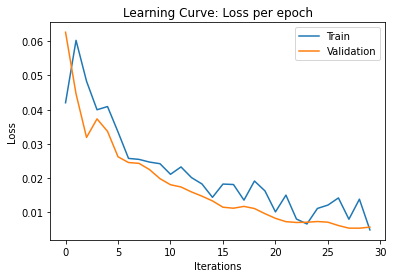

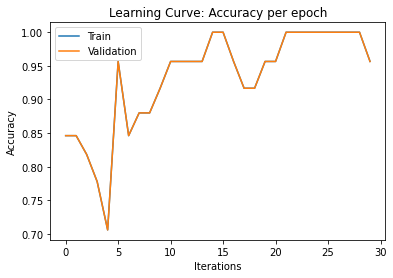

In [15]:
RH.plot_learning_curve(*try_train)

It seem that we overfitted well (f1 score of 1) and we are ready for training:

In [25]:
from pretrained.get_pretrained_roberta import GetPretrainedRoberta 
from pretrained.modify_roberta import ModifyRoberta

roberta_model2 = GetPretrainedRoberta()
ModifyRoberta.modify_binary_output(roberta_model2.model) 
ModifyRoberta.modify_only_train_calssifier(roberta_model2.model)

In [28]:
len(val_data)

4552

In [29]:
from roberta.roberta_handle import RobertaHandler as RH

handler = RH()

trained_softmax = handler.train_roberta_model(val_data=val_data ,batch_size=500, check_point_path=None, learning_rate=1e-3, num_epoches=30, train_data=train_data, model=roberta_model2)


====> Epoch: 1 Average train loss: 0.0012, train acc: 0.7147, Average val loss: 0.0011, val acc: 0.7047
====> Epoch: 2 Average train loss: 0.0011, train acc: 0.7281, Average val loss: 0.0010, val acc: 0.7213
====> Epoch: 3 Average train loss: 0.0010, train acc: 0.7326, Average val loss: 0.0010, val acc: 0.7278
====> Epoch: 4 Average train loss: 0.0010, train acc: 0.7290, Average val loss: 0.0010, val acc: 0.7290
====> Epoch: 5 Average train loss: 0.0010, train acc: 0.7397, Average val loss: 0.0009, val acc: 0.7369
====> Epoch: 6 Average train loss: 0.0010, train acc: 0.7445, Average val loss: 0.0010, val acc: 0.7321
====> Epoch: 7 Average train loss: 0.0010, train acc: 0.7471, Average val loss: 0.0009, val acc: 0.7421
====> Epoch: 8 Average train loss: 0.0010, train acc: 0.7468, Average val loss: 0.0009, val acc: 0.7396
====> Epoch: 9 Average train loss: 0.0010, train acc: 0.7501, Average val loss: 0.0009, val acc: 0.7447
====> Epoch: 10 Average train loss: 0.0010, train acc: 0.7547, A

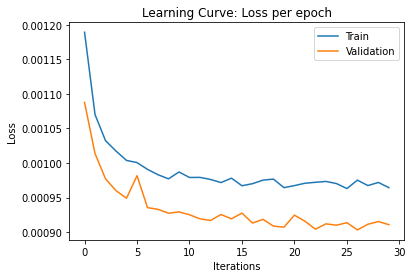

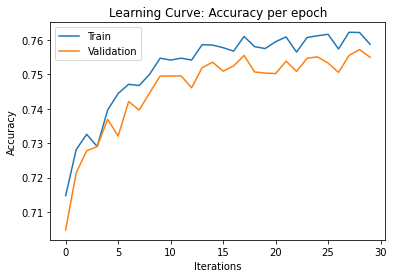

In [30]:
RH.plot_learning_curve(*trained_softmax)

In [31]:
roberta_model2.model.save('/content/gdrive/My Drive/NLP_Project/model_b500_lr003_val_acc75_augdata.pk')

AttributeError: ignored

In [34]:
for param in roberta_model2.model.parameters():
  param.requires_grad = True

In [ ]:
trained_softmax2 = handler.train_roberta_model(val_data=val_data ,batch_size=32, check_point_path=None, learning_rate=4e-6, num_epoches=30, train_data=train_data, model=roberta_model2)
RH.plot_learning_curve(*trained_softmax2)

In [ ]:
results = pd.read_csv(sample_submission_path)
results.target = clf.predict(count_vectorizer.transform(test_df["text"]))
results.to_csv("submission.csv", index=False)

In [12]:
! pip install -q datasets
!pip install evaluate


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 18.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 7.0 MB/s eta 0:00:00


In [13]:
from torch.utils.data import Dataset
from datasets import Dataset,DatasetDict #-> Hugging Face

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)


[autoreload of urllib3.packages.six failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.8/dist-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/usr/local/lib/python3.8/dist-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/usr/local/lib/python3.8/dist-packages/IPython/extensions/autoreload.py", line 287, in update_class
    old_obj = getattr(old, key)
  File "/usr/local/lib/python3.8/dist-packages/urllib3/packages/six.py", line 97, in __get__
    setattr(obj, self.name, result)  # Invokes __set__.
AttributeError: 'NoneType' object has no attribute 'cStringIO'
]
[autoreload of urllib3.util.ssl_ failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/extensions/autorelo

In [14]:
def tokenize_func(x): 
  return roberta.tokenizer(x["text"])

In [15]:
tokenized_train = train_dataset.map(tokenize_func, batched=True)
tokenized_val = val_dataset.map(tokenize_func, batched=True)

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [16]:
tokenized_train = tokenized_train.rename_columns({'target':'labels'})
tokenized_val = tokenized_val.rename_columns({'target':'labels'})

In [17]:
from transformers import TrainingArguments,Trainer

In [18]:
import numpy as np
import evaluate

def compute_metrics(eval_preds):
    metric = evaluate.load("f1")
    preds, labels = eval_preds
    return metric.compute(predictions=preds, references=labels)